# Overview

Example to show how to deploy a pretrained model from tensorflow hub using elastic inference.  Most of the code has been adapted from this repo notebook - 

* https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_serving_container/tensorflow_serving_container.ipynb
* https://medium.com/globant/deploy-tensorflow-hub-models-on-amazon-sagemaker-e41c9cc470b5
* https://aws.amazon.com/blogs/machine-learning/training-and-deploying-models-using-tensorflow-2-with-the-object-detection-api-on-amazon-sagemaker/
* https://aws.amazon.com/blogs/machine-learning/reduce-compuer-vision-inference-latency-using-grpc-with-tensorflow-serving-on-amazon-sagemaker/
* https://github.com/aws-samples/amazon-sagemaker-tensorflow-serving-grpc

## Setup

First, we need to ensure we have an up-to-date version of the SageMaker Python SDK, and install a few
additional python packages.

In [1]:
# install dependencies
!pip install -U sagemaker
!pip install -U --quiet opencv-python 
!pip install -U tensorflow==2.3.0

  Using cached sagemaker-2.48.2-py2.py3-none-any.whl
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.1.1
    Uninstalling dill-0.3.1.1:
      Successfully uninstalled dill-0.3.1.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.45.0
    Uninstalling sagemaker-2.45.0:
      Successfully uninstalled sagemaker-2.45.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.31.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.4 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via

In [35]:
%matplotlib inline

In [19]:
import os
import pathlib
import json

import matplotlib
import matplotlib.pyplot as plt
import visualization_utils as viz_utils


import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

Next, we'll get the IAM execution role from our notebook environment, so that SageMaker can access resources in your AWS account later in the example.

In [3]:
from sagemaker import get_execution_role
sagemaker_role = get_execution_role()

## Download and prepare a model from TensorFlow2 Model Zoo

The TensorFlow Serving Container works with any model stored in TensorFlow's [SavedModel format](https://www.tensorflow.org/guide/saved_model). This could be the output of your own training job or a model trained elsewhere. For this example, we will use a pre-trained version of the EfficientDet D1 object detection model from [TensorFlow 2 Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).



In [6]:
tf.__version__

'2.3.0'

In [7]:
# Download the saved model and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz
!tar -xvf efficientdet_d2_coco17_tpu-32.tar.gz --no-same-owner

--2021-07-14 21:28:27--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.115.128, 2607:f8b0:4004:82f::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.115.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62929273 (60M) [application/x-tar]
Saving to: ‘efficientdet_d2_coco17_tpu-32.tar.gz’

efficientdet_d2_coc 100%[===================>]  60.01M   149MB/s    in 0.4s    

2021-07-14 21:28:27 (149 MB/s) - ‘efficientdet_d2_coco17_tpu-32.tar.gz’ saved [62929273/62929273]

efficientdet_d2_coco17_tpu-32/
efficientdet_d2_coco17_tpu-32/checkpoint/
efficientdet_d2_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d2_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d2_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d2_coco17_tpu-32/pipeline.config
efficientdet_d2_coco17_tpu-32/saved_model/
efficientd

In [9]:
# make directories and move model into directory
!mkdir model
!mkdir model/1
!mv efficientdet_d2_coco17_tpu-32/saved_model/* model/1/

mkdir: cannot create directory ‘model’: File exists
mkdir: cannot create directory ‘model/1’: File exists


In [10]:
model_path = 'model/1/'

### Load the saved model to test locally

In [11]:
import time
start_time = time.time()
tf.keras.backend.clear_session()
tf.get_logger().setLevel('ERROR')
detect_fn = tf.saved_model.load(model_path)
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 28.601435899734497s


In [12]:
detect_fn.signatures['serving_default'].output_dtypes

{'detection_anchor_indices': tf.float32,
 'detection_classes': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_scores': tf.float32,
 'detection_boxes': tf.float32,
 'num_detections': tf.float32,
 'raw_detection_scores': tf.float32,
 'raw_detection_boxes': tf.float32}

In [13]:
# define class mapping - from COCO
category_index = {
    1: {'id': 1, 'name': 'person'},
    2: {'id': 2, 'name': 'bicycle'},
    3: {'id': 3, 'name': 'car'},
    4: {'id': 4, 'name': 'motorcycle'},
    5: {'id': 5, 'name': 'airplane'},
    6: {'id': 6, 'name': 'bus'},
    7: {'id': 7, 'name': 'train'},
    8: {'id': 8, 'name': 'truck'},
    9: {'id': 9, 'name': 'boat'},
    10: {'id': 10, 'name': 'traffic light'},
    11: {'id': 11, 'name': 'fire hydrant'},
    13: {'id': 13, 'name': 'stop sign'},
    14: {'id': 14, 'name': 'parking meter'},
    15: {'id': 15, 'name': 'bench'},
    16: {'id': 16, 'name': 'bird'},
    17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'},
    19: {'id': 19, 'name': 'horse'},
    20: {'id': 20, 'name': 'sheep'},
    21: {'id': 21, 'name': 'cow'},
    22: {'id': 22, 'name': 'elephant'},
    23: {'id': 23, 'name': 'bear'},
    24: {'id': 24, 'name': 'zebra'},
    25: {'id': 25, 'name': 'giraffe'},
    27: {'id': 27, 'name': 'backpack'},
    28: {'id': 28, 'name': 'umbrella'},
    31: {'id': 31, 'name': 'handbag'},
    32: {'id': 32, 'name': 'tie'},
    33: {'id': 33, 'name': 'suitcase'},
    34: {'id': 34, 'name': 'frisbee'},
    35: {'id': 35, 'name': 'skis'},
    36: {'id': 36, 'name': 'snowboard'},
    37: {'id': 37, 'name': 'sports ball'},
    38: {'id': 38, 'name': 'kite'},
    39: {'id': 39, 'name': 'baseball bat'},
    40: {'id': 40, 'name': 'baseball glove'},
    41: {'id': 41, 'name': 'skateboard'},
    42: {'id': 42, 'name': 'surfboard'},
    43: {'id': 43, 'name': 'tennis racket'},
    44: {'id': 44, 'name': 'bottle'},
    46: {'id': 46, 'name': 'wine glass'},
    47: {'id': 47, 'name': 'cup'},
    48: {'id': 48, 'name': 'fork'},
    49: {'id': 49, 'name': 'knife'},
    50: {'id': 50, 'name': 'spoon'},
    51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'},
    53: {'id': 53, 'name': 'apple'},
    54: {'id': 54, 'name': 'sandwich'},
    55: {'id': 55, 'name': 'orange'},
    56: {'id': 56, 'name': 'broccoli'},
    57: {'id': 57, 'name': 'carrot'},
    58: {'id': 58, 'name': 'hot dog'},
    59: {'id': 59, 'name': 'pizza'},
    60: {'id': 60, 'name': 'donut'},
    61: {'id': 61, 'name': 'cake'},
    62: {'id': 62, 'name': 'chair'},
    63: {'id': 63, 'name': 'couch'},
    64: {'id': 64, 'name': 'potted plant'},
    65: {'id': 65, 'name': 'bed'},
    67: {'id': 67, 'name': 'dining table'},
    70: {'id': 70, 'name': 'toilet'},
    72: {'id': 72, 'name': 'tv'},
    73: {'id': 73, 'name': 'laptop'},
    74: {'id': 74, 'name': 'mouse'},
    75: {'id': 75, 'name': 'remote'},
    76: {'id': 76, 'name': 'keyboard'},
    77: {'id': 77, 'name': 'cell phone'},
    78: {'id': 78, 'name': 'microwave'},
    79: {'id': 79, 'name': 'oven'},
    80: {'id': 80, 'name': 'toaster'},
    81: {'id': 81, 'name': 'sink'},
    82: {'id': 82, 'name': 'refrigerator'},
    84: {'id': 84, 'name': 'book'},
    85: {'id': 85, 'name': 'clock'},
    86: {'id': 86, 'name': 'vase'},
    87: {'id': 87, 'name': 'scissors'},
    88: {'id': 88, 'name': 'teddy bear'},
    89: {'id': 89, 'name': 'hair drier'},
    90: {'id': 90, 'name': 'toothbrush'},
}

In [36]:
# predict - locally
from tensorflow.keras.preprocessing import image
HEIGHT = 1024
WIDTH  = 1024
def image_file_to_tensor(path):
    
    img = Image.open(path).convert('RGB')
   
    img = img.resize((WIDTH, HEIGHT))
    
    img_array = image.img_to_array(img)
   
    img_array =img_array.reshape((HEIGHT, WIDTH, 3)).astype(np.uint8) #"channels_last"
    return img_array

elapsed = []
image_path = 'test_images/birds.jpg'
print(image_path)
start_time1 = time.time()
img_array = image_file_to_tensor(image_path)
input_tensor = np.expand_dims(img_array, axis=0)

start_time2 = time.time()
detections = detect_fn(input_tensor)
end_time = time.time()
print('Elapsed time including preprocessing: ' + str(end_time - start_time1) + ' second per image')
print('Elapsed time prediction only: ' + str(end_time - start_time2) + ' second per image')

test_images/birds.jpg
Elapsed time including preprocessing: 1.0879251956939697 second per image
Elapsed time prediction only: 0.9823744297027588 second per image


In [37]:
def plot_obj_detections(img,response,category_index):
    
    detection_boxes = np.array(response['detection_boxes'][0])
    detection_classes = [int(x) for x in response['detection_classes'][0]]
    detection_scores = np.array(response['detection_scores'][0])

    viz_utils.visualize_boxes_and_labels_on_image_array(
        img,
        detection_boxes,
        detection_classes,
        detection_scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=100,
        min_score_thresh=0.60,
        agnostic_mode=False)

    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()

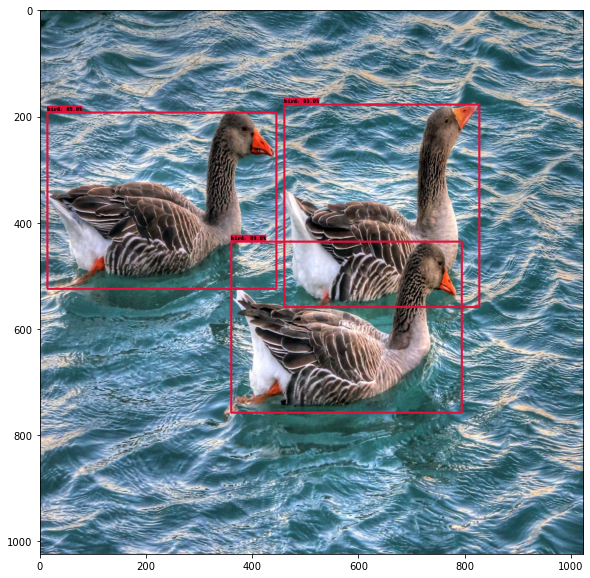

In [38]:
plot_obj_detections(img_array,detections,category_index)

Next we need to create a model archive file containing the exported model.

## Create a model archive file

SageMaker models need to be packaged in `.tar.gz` files. When your endpoint is provisioned, the files in the archive will be extracted and put in `/opt/ml/model/` on the endpoint. 

In [39]:
!tar -C "$PWD" -czf model.tar.gz model/

## Upload the model archive file to S3

We now have a suitable model archive ready in our notebook. We need to upload it to S3 before we can create a SageMaker Model that. We'll use the SageMaker Python SDK to handle the upload.

In [40]:
from sagemaker.session import Session

model_data = Session().upload_data(path='model.tar.gz', key_prefix='efficientdet')
print('model uploaded to: {}'.format(model_data))

model uploaded to: s3://sagemaker-us-east-1-431615879134/efficientdet/model.tar.gz


## Create a SageMaker Model and Endpoint with REST in-server communication and gRPC in-server communication

Now that the model archive is in S3, we can create a Model and deploy it to an 
Endpoint with a few lines of python code:

### OPTION 1 - Custom inference script for preprocessing and REST communication with TensorFlow serving

In [ ]:
from sagemaker.tensorflow.serving import TensorFlowModel

#use an env variable to set whether using rest call to TFS 
model2 = TensorFlowModel(source_dir='source_dir',entry_point='inference.py',model_data=model_data, role=sagemaker_role, framework_version='2.3.0', env = {'PREDICT_USING_GRPC' : 'false'})
predictor2 = model2.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge', accelerator_type='ml.eia2.xlarge')

In [22]:
import boto3
birds_image = open('birds.jpg', 'rb').read()
endpoint_name = endpoint_name = predictor2.endpoint_name
print(endpoint_name)
runtime_client = boto3.client('runtime.sagemaker')
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image',     
                                   Body=birds_image)
res = response['Body'].read().decode('ascii')

tensorflow-inference-2021-07-14-20-25-57-108


In [23]:
# write output to a file
text_file = open("Output2.txt", "w")
text_file.write(res)
text_file.close()

### OPTION 2 - Custom inference script for preprocessing and gRPC communication with TensorFlow serving

In [66]:
%%time
from sagemaker.tensorflow.serving import TensorFlowModel
#use an env variable to set whether using grpc
model2 = TensorFlowModel(source_dir='source_dir',entry_point='inference.py',model_data=model_data, role=sagemaker_role, framework_version='2.3.0', env = {'PREDICT_USING_GRPC' : 'true'})
predictor2 = model2.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge', accelerator_type='ml.eia2.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------------!CPU times: user 8.08 s, sys: 878 ms, total: 8.96 s
Wall time: 7min 40s


In [ ]:
import boto3
image_path = 'test_images/birds_lowres.jpg'
birds_image = open(image_path, 'rb').read()
endpoint_name = endpoint_name = predictor2.endpoint_name
print(endpoint_name)
runtime_client = boto3.client('runtime.sagemaker')
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image',     
                                   Body=birds_image)
res = response['Body'].read().decode('ascii')
resj = json.loads(res)

In [78]:
img_array = image_file_to_tensor(image_path)

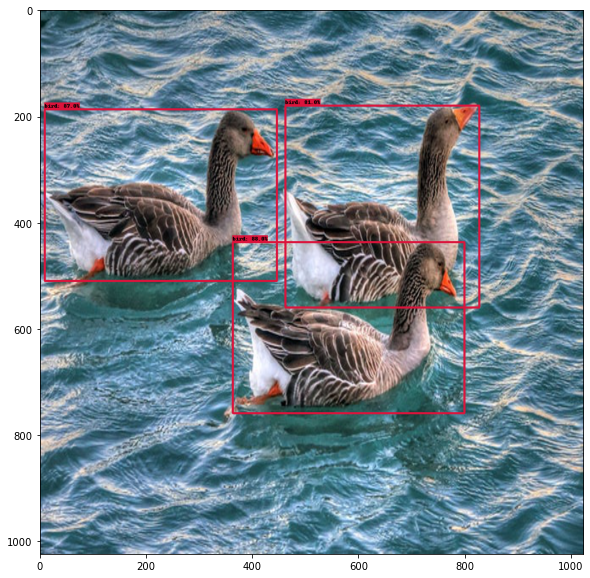

In [80]:
plot_obj_detections(img_array,resj,category_index)

## Additional Information

The TensorFlow Serving Container supports additional features not covered in this notebook, including support for:

- TensorFlow Serving REST API requests - classify and regress requests
- CSV input
- Other JSON formats

For information on how to use these features, refer to the documentation in the 
[SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst).

## Cleaning up

To avoid incurring charges to your AWS account for the resources used in this tutorial, you need to delete the SageMaker Endpoint.

In [ ]:
predictor.delete_endpoint()
predictor2.delete_endpoint()